In [77]:
import pandas as pd

# Load the uploaded Excel file to check its contents
file_path = 'expense.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the data to understand its structure
data.head()


,App No.,Rent,Residence Type (Rented-Yes/No),Grand Total Expense,Total Income,income band,Family Members,Branch,Expense percentage,Branch category
0,APPL05190674,0,No,55146.0,876995.0,E: >50k,1,Indore,30.003788,E
1,APPL05190682,0,No,55146.0,876995.0,E: >50k,1,Indore,30.003788,E
2,APPL05182253,0,No,17000.0,870000.0,E: >50k,1,Nagpur-CA Road,25.470275,B
3,APPL05172860,0,No,58000.0,860000.0,E: >50k,1,Agra-Fatehabad Road,31.042949,E
4,APPL05014586,0,No,11750.0,858000.0,E: >50k,4,Dewas,34.092955,G


Data Cleaning

In [78]:
from scipy import stats
import numpy as np

In [79]:
# 1. Identify and handle missing values
missing_summary = data.isnull().sum()

In [80]:
# Filling missing values in 'Total Income' and 'Grand Total Expense' with median as they're essential numeric features
data['Total Income'].fillna(data['Total Income'].median(), inplace=True)
data['Grand Total Expense'].fillna(data['Grand Total Expense'].median(), inplace=True)
data['Expense percentage'].fillna(data['Expense percentage'].median(), inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_18392\1776833029.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Total Income'].fillna(data['Total Income'].median(), inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_18392\1776833029.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [81]:
# 2. Outlier detection and removal for numerical columns
# We'll use the IQR method to remove outliers from 'Rent', 'Grand Total Expense', 'Total Income', and 'Expense percentage'
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Filter for rows within 1.5 * IQR range
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

In [82]:
# Remove outliers for the selected columns
data_cleaned = remove_outliers_iqr(data, ['Rent', 'Grand Total Expense', 'Total Income', 'Expense percentage'])

In [83]:
data_cleaned['Rent'] = pd.to_numeric(data_cleaned['Rent'], errors='coerce')
data_cleaned['Grand Total Expense'] = pd.to_numeric(data_cleaned['Grand Total Expense'], errors='coerce')
data_cleaned['Total Income'] = pd.to_numeric(data_cleaned['Total Income'], errors='coerce')
data_cleaned['Expense percentage'] = pd.to_numeric(data_cleaned['Expense percentage'], errors='coerce')


In [84]:
# 3. Check skewness and apply transformations if needed
skewness = data_cleaned[['Rent', 'Grand Total Expense', 'Total Income', 'Expense percentage']].apply(lambda x: x.skew())
skewness

Rent                   0.000000
Grand Total Expense    0.559732
Total Income           0.763821
Expense percentage     0.159689
dtype: float64

In [85]:
# Apply log transformation for highly skewed columns
for col in skewness[abs(skewness) > 1].index:
    data_cleaned[col] = np.log1p(data_cleaned[col])  # log1p to handle zero values gracefully

In [86]:
# 4. Convert categorical variables
# Encoding 'Residence Type', 'Branch', and 'Branch category' with one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, columns=['Residence Type (Rented-Yes/No)', 'Branch', 'Branch category'], drop_first=True)


In [87]:
# 5. Remove unnecessary columns
data_cleaned = data_cleaned.drop(columns=['App No.', 'income band'])


In [88]:
# Display the cleaned data's first few rows and summary
data_cleaned.head(), data_cleaned.describe()

(      Rent  Grand Total Expense  Total Income  Family Members  \
 6417     0              18239.0       70300.0               1   
 6418     0              16000.0       70300.0               1   
 6419     0              10000.0       70300.0               1   
 6420     0               7900.0       70300.0               1   
 6421     0              16230.0       70295.0               1   
 
       Expense percentage  Branch_Agra  Branch_Agra-Fatehabad Road  \
 6417           28.279873        False                       False   
 6418           31.042949        False                        True   
 6419           27.691684        False                       False   
 6420           35.158986        False                       False   
 6421           28.353145        False                       False   
 
       Branch_Ahmedabad  Branch_Ahmedabad-Narol  Branch_Ahmednagar  ...  \
 6417             False                   False              False  ...   
 6418             False       

In [89]:
# data_cleaned['Rent'] = pd.to_numeric(data_cleaned['Rent'], errors='coerce')
# data_cleaned['Grand Total Expense'] = pd.to_numeric(data_cleaned['Grand Total Expense'], errors='coerce')
# data_cleaned['Total Income'] = pd.to_numeric(data_cleaned['Total Income'], errors='coerce')
# data_cleaned['Expense percentage'] = pd.to_numeric(data_cleaned['Expense percentage'], errors='coerce')


Data Visualization

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.02, 'Data Distribution and Skewness After Cleaning')

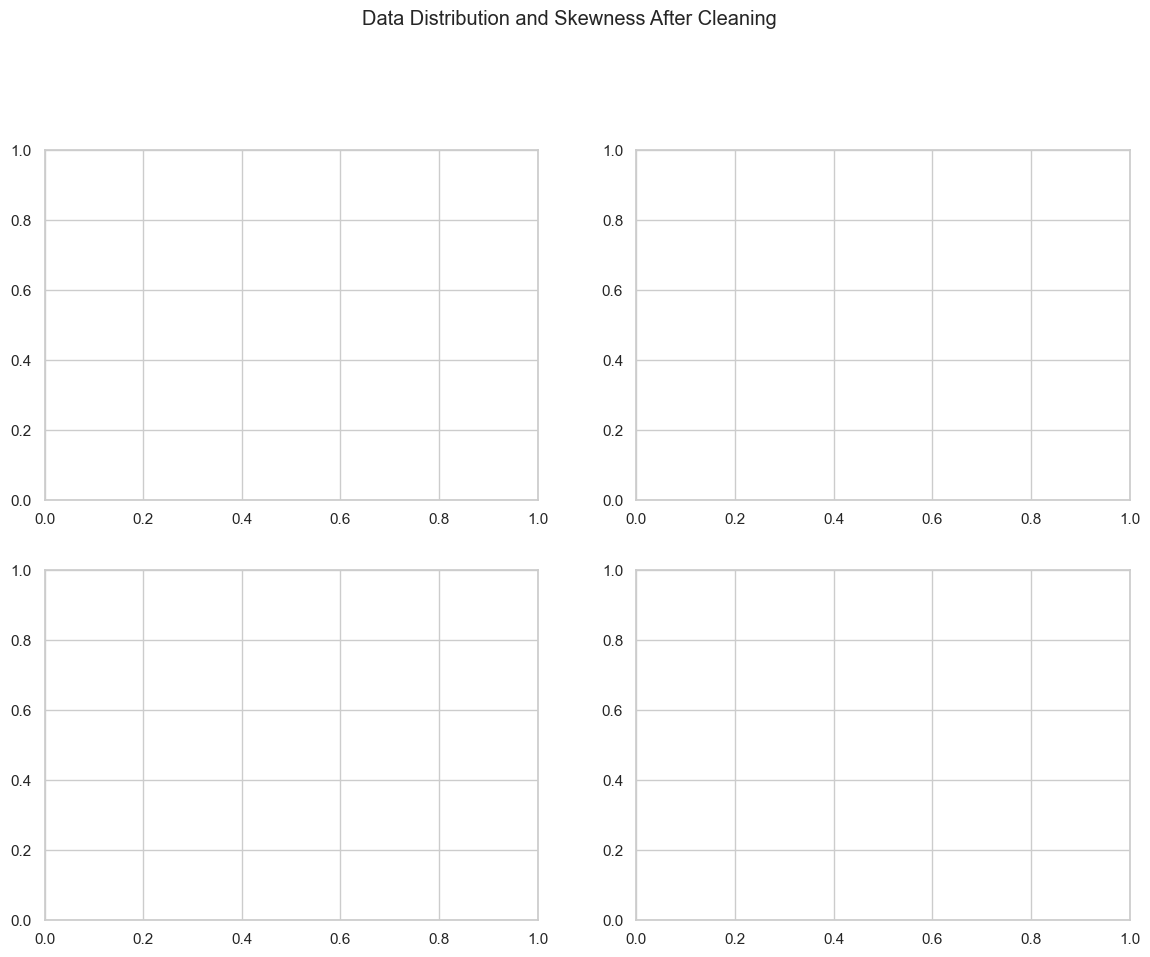

In [91]:
# Set up the visual style
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Data Distribution and Skewness After Cleaning", y=1.02)  # Adjust title position if needed


In [92]:

# 1. Rent Distribution
sns.histplot(data_cleaned['Rent'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Rent Distribution")


Text(0.5, 1.0, 'Rent Distribution')

In [93]:
# 2. Grand Total Expense Distribution
sns.histplot(data_cleaned['Grand Total Expense'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title("Grand Total Expense Distribution")

Text(0.5, 1.0, 'Grand Total Expense Distribution')

In [94]:
# 3. Total Income Distribution
sns.histplot(data_cleaned['Total Income'], kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title("Total Income Distribution")

Text(0.5, 1.0, 'Total Income Distribution')

In [95]:
# 4. Expense Percentage Distribution
sns.histplot(data_cleaned['Expense percentage'], kde=True, ax=axes[1, 1], color='violet')
axes[1, 1].set_title("Expense Percentage Distribution")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 640x480 with 0 Axes>

model

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming the target variable for predicting loan payment capability is 'Loan_Payment_Ability' (replace with actual column name if different)
# Here, we'll assume it's a binary column with values like 0 (unable to pay) and 1 (able to pay)

# Splitting data into features (X) and target (y)
X = data_cleaned.drop(columns=['Expense percentage'])  # Drop the target column from features
y = data_cleaned['Expense percentage'].astype('int')


In [97]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [106]:
X_train

,Rent,Grand Total Expense,Total Income,Family Members,Branch_Agra,Branch_Agra-Fatehabad Road,Branch_Ahmedabad,Branch_Ahmedabad-Narol,Branch_Ahmednagar,Branch_Ajmer,...,Branch_Washim,Branch_Yamuna Nagar,Branch_Yavatmal,Branch category_B,Branch category_C,Branch category_D,Branch category_E,Branch category_F,Branch category_G,Branch category_H
16497,0,12000.0,47560.0,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
11755,0,7500.0,55000.0,2,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
11781,0,12800.0,54914.0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
53813,0,7800.0,25000.0,4,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
52065,0,10600.0,25400.0,4,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69371,0,9200.0,18148.0,1,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
50589,0,10691.0,26000.0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7570,0,14800.0,65847.0,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
25162,0,10110.0,39500.0,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [107]:
y_train

16497    28
11755    31
11781    30
53813    29
52065    27
         ..
69371    24
50589    33
7570     29
25162    28
71853    30
Name: Expense percentage, Length: 42430, dtype: int32

In [98]:
# Initialize and train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10,random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7336816057189992


In [100]:
# Display accuracy, classification report, and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, classification_rep, conf_matrix

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(0.7336816057189992,
 '              precision    recall  f1-score   support\n\n          23       0.00      0.00      0.00        56\n          24       0.00      0.00      0.00       418\n          25       0.34      1.00      0.50       492\n          26       1.00      0.35      0.52       480\n          27       0.79      1.00      0.88      1146\n          28       1.00      0.48      0.65      2012\n          29       0.73      1.00      0.84      2772\n          30       1.00      0.41      0.58      3074\n          31       0.63      1.00      0.77      3056\n          32       0.54      1.00      0.70       782\n          33       0.00      0.00      0.00       670\n          34       1.00      0.87      0.93       343\n          35       0.98      1.00      0.99      2392\n          36       0.00      0.00      0.00       378\n          37       0.00      0.00      0.00       114\n\n    accuracy                           0.73     18185\n   macro avg       0.53      0.54     